# 5 与机器学习框架整合 

## 5.2 准备工作

In [3]:
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import tir as T
from tvm.script import relax as R

In [4]:
import torch
import torch.nn as nn
from torch import fx
from torch.nn import functional as F
import torchvision

## 5.3 通过builder构建IRModule
构建IRModule：
1. TVMScript(小模型，手动定义)
2. Builder(大模型)

### 5.3.1 从张量表达式(TE)构建TensorIR

In [5]:
from tvm import te

In [6]:
A = te.placeholder((128, 128), name='A', dtype='float32')
B = te.placeholder((128, 128), name='B', dtype='float32')

In [7]:
type(A), A

(tvm.te.tensor.Tensor, Tensor(shape=[128, 128], op.name=A))

In [8]:
# te_matmul
def te_matmul(A: te.Tensor, B: te.Tensor):
    m = A.shape[0]
    n = B.shape[1]
    k = te.reduce_axis((0, A.shape[1]), name='k')
    return te.compute((m, n), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name='matmul')

In [9]:
C = te_matmul(A, B)
type(te.create_prim_func([A, B, C]))

tvm.tir.function.PrimFunc

In [10]:
te.create_prim_func([A, B, C]).show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [11]:
def te_relu(A: te.Tensor):
    return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name='relu')

In [12]:
X1 = te.placeholder((10, ), name='X1', dtype='float32')
Y1 = te_relu(X1)
te.create_prim_func([X1, Y1]).show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [13]:
X2 = te.placeholder((10, 20), name='X2', dtype='float32')
Y2 = te_relu(X2)
te.create_prim_func([X2, Y2]).show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


te API运行融合算子

In [14]:
C = te_matmul(A, B)
D = te_relu(C)
te.create_prim_func([A, B, D]).show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


```python
te.create_prim_func([A, B, C, D]).show()
```
区别，显式传入C需要在参数输入时也对应传入，隐式传入则是由tir申请中间变量

### 5.3.2 使用BlockBuilder构建IRModule(IRModule中包含多个TensorIR)

In [15]:
A = relax.Var("A", relax.TensorStructInfo((128, 128), 'float32'))
B = relax.Var("B", relax.TensorStructInfo((128, 128), 'float32'))

In [16]:
bb = relax.BlockBuilder()
with bb.function('main'):
    with bb.dataflow():
        C = bb.emit_te(te_matmul, A, B)
        D = bb.emit_te(te_relu, C)
        R = bb.emit_output(D)
    bb.emit_func_output(R, params=[A, B])

MyModule = bb.get()
MyModule.show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


### 5.3.3 深入理解blockbuilder API

BlockBuilder 带有与 Relax 函数中相应的作用域。例如，bb.dataflow() 创建一个 dataflow block，其中所有对 BlockBuilder 的调用都处在 dataflow block 的作用域中

```python
with bb.function('main'):
    with bb.dataflow():
        # every emit call generates a variable inside a dataflow block.
```

In [17]:
# DatalowVar ---> 计算图中间值
type(C)

tvm.relax.expr.DataflowVar

Relax中函数每一行都由emit_te调用生成
```python
lv = R.call_tir(te_matmul, (A, B), relax.TensorStructureInfo((128, 128), dtype='float32))
C = bb.emit_te(te_mmatmul, A, B)
```

在幕后，bb.emit_te 做了以下事情：
1. 为 A 和 B 创建一个输入 te.placeholder。
2. 通过 te_matmul 函数运行它们。
3. 调用 te.create_prim_func 来创建一个 TensorIR 函数。
4. 通过 call_tir 生成对函数的调用。


bb.emit_output()创建每个dataflow block的输出变量，即可在计算图之外引用的变量
```python
with bb.dataflow():
    ...
    R = bb.emmit_output(D)
```

最后，函数输出由 bb.emit_func_output 标记。 我们只能在每个函数作用域内调用一次 emit_func_output。
```python
with bb.function('main'):
    ...
    with bb.emit_func_output(R, params=[A, B])

with bb.dunction('main', params=[A, B]):
    ...
    bb.emmit_func_output(R)
```

## Pytorch ---> tvm.IRModule

**key**: 计算图抽象 

process: nn.Module(torch) ---> Computation graph(torch) ---> IRModule

In [18]:
# torch version
class MyModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.rand(128, 128))
    
    def forward(self, x):
        x = torch.matmul(x, self.weight)
        x = torch.relu(x)
        return x


### 5.4.1 创建TorchFX GraphModule

使用TorchFX表示Pytorch模型计算图

In [19]:
model = MyModel()
fx_module = fx.symbolic_trace(model)
type(fx_module)

torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl

In [20]:
fx_module.graph.print_tabular()

opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x7fd936bffec0>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x7fd936bffec0>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


## 5.4.2 构造映射函数
让我们定义整体的翻译逻辑。 主要流程如下：
1. 创建一个 node_map，将 fx.Node 映射到相应的 relax.Var，该 relax.Var 代表 IRModule 中的已翻译节点。
2. 以拓扑顺序迭代 FX 图中的节点。
3. 给定映射输入，获取节点的映射输出。

In [21]:
print(fx_module.graph, fx_module.code, fx_module.__str__)
for node in fx_module.graph.nodes:
    print(node, type(node), node.op, node.target)


graph():
    %x : [#users=1] = placeholder[target=x]
    %weight : [#users=1] = get_attr[target=weight]
    %matmul : [#users=1] = call_function[target=torch.matmul](args = (%x, %weight), kwargs = {})
    %relu : [#users=1] = call_function[target=torch.relu](args = (%matmul,), kwargs = {})
    return relu 


def forward(self, x):
    weight = self.weight
    matmul = torch.matmul(x, weight);  x = weight = None
    relu = torch.relu(matmul);  matmul = None
    return relu
     <bound method GraphModule.__str__ of MyModel()>
x <class 'torch.fx.node.Node'> placeholder x
weight <class 'torch.fx.node.Node'> get_attr weight
matmul <class 'torch.fx.node.Node'> call_function <built-in method matmul of type object at 0x7fd936bffec0>
relu <class 'torch.fx.node.Node'> call_function <built-in method relu of type object at 0x7fd936bffec0>
output <class 'torch.fx.node.Node'> output output


In [24]:
def map_param(param: nn.Parameter):
    ndim = param.data.shape
    return relax.const(param.data.cpu().numpy(), 'float32')

def fetch_attr(fx_mod, target: str):
    target_atoms = target.split('.')
    attr_itr = fx_mod
    for i, atom in enumerate(target_atoms):
        if not hasattr(attr_itr, atom):
            raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
        attr_itr = getattr(attr_itr, atom)
    return attr_itr

def from_fx(fx_mod: torch.fx.GraphModule, input_shapes, call_function_map, call_module_map):
    input_index = 0
    node_map = {}
    named_modules = dict(fx_mod.named_modules())

    bb = relax.BlockBuilder()

    fn_inputs = []
    fn_output = None
    with bb.function('main'):
        with bb.dataflow():
            for node in fx_mod.graph.nodes:
                if node.op == "placeholder":
                    shape = input_shapes[input_index]
                    input_index = input_index + 1
                    input_var = relax.Var(node.target, relax.TensorStructInfo(shape, dtype='float32'))
                    fn_inputs.append(input_var)
                    node_map[node] = input_var
                elif node.op == "get_attr":
                    node_map[node] = map_param(fetch_attr(fx_mod, node.target))
                elif node.op == "call_function":
                    node_map[node] = call_function_map[node.target](bb, node_map, node)
                elif node.op == "call_module":
                    named_module = named_modules[node.target]
                    node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
                elif node.op == "output":
                    output = node_map[node.args[0]]
                    assert fn_output is None
                    fn_output = bb.emit_output(output)
        
        bb.emit_func_output(fn_output, fn_inputs)
    return bb.get()



In [25]:
def map_matmul(bb, node_map, node):
    A = node_map[node.args[0]]
    W = node_map[node.args[1]]
    return bb.emit_te(te_matmul, A, W)

def map_relu(bb, node_map, node):
    A = node_map[node.args[0]]
    return bb.emit_te(te_relu, A)

MyModule = from_fx(fx_module, [(1, 128)],
                call_function_map={torch.matmul: map_matmul, torch.relu: map_relu},
                call_module_map={})

MyModule.show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


## 5.5 FashionMNist

In [27]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

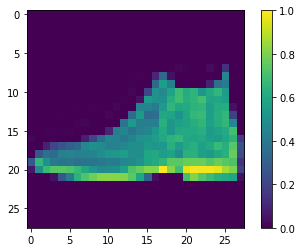

Class: Ankle boot


In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [29]:
# torch version
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear0 = nn.Linear(784, 128, bias=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(128, 10, bias=True)
    
    def forward(self, x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x

In [30]:
import pickle as pkl

mlp_model = MLP()
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params['w0'])
mlp_model.linear0.bias.data = torch.from_numpy(mlp_params['b0'])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params['w1'])
mlp_model.linear1.bias.data = torch.from_numpy(mlp_params['b1'])

In [32]:
torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))

pred_kind = np.argmax(torch_res.detach().numpy(), axis=1)
print("Torch Prediction:", class_names[pred_kind[0]])


Torch Prediction: Ankle boot


In [33]:
# 预定义库 TVM TOPI
from tvm import topi
def map_nn_linear(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    
    y = bb.emit_te(topi.nn.dense, x, w)
    return bb.emit_te(topi.add, y, b)

def map_nn_relu(bb, node_map, node, nn_mode):
    return map_relu(bb, node_map, node)

MLPModule = from_fx(fx.symbolic_trace(mlp_model),
                    input_shapes=[(1, 784)],
                    call_function_map={},
                    call_module_map={
                        torch.nn.Linear: map_nn_linear,
                        torch.nn.ReLU: map_nn_relu
                    })

MLPModule.show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [34]:
ex = relax.vm.build(MLPModule, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())

data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm['main'](data_nd)
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])


MLPModule Prediction: Ankle boot


## 5.6 翻译成高层次算子

In [37]:
def map_nn_relu_op(bb, node_map, node, nn_mod):
    A = node_map[node.args[0]]
    return bb.emit(relax.op.nn.relu(A))

def map_nn_linear_op(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    b = None
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    return bb.emit(relax.op.linear(x, w, b))

MLPModuleHighLevel = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shape = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear_op,
        torch.nn.ReLU: map_nn_relu_op,
    },
)

MLPModuleHighLevel.show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [38]:
ex = relax.vm.build(MLPModuleHighLevel, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())

data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm['main'](data_nd)
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModuleHighLevel Prediction:", class_names[pred_kind[0]])


TVMError: Traceback (most recent call last):
  8: TVMFuncCall
  7: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime::TypedPackedFunc<tvm::IRModule (tvm::relax::ExecBuilder, tvm::IRModule)>::AssignTypedLambda<tvm::IRModule (*)(tvm::relax::ExecBuilder, tvm::IRModule)>(tvm::IRModule (*)(tvm::relax::ExecBuilder, tvm::IRModule), std::string)::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}> >::Call(tvm::runtime::PackedFuncObj const*, tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*)
  6: tvm::relax::relax_vm::VMCodeGen(tvm::relax::ExecBuilder, tvm::IRModule)
  5: tvm::relax::relax_vm::CodeGenVM::Run(tvm::relax::ExecBuilder, tvm::IRModule)
  4: tvm::relax::relax_vm::CodeGenVM::Codegen(tvm::relax::Function const&)
  3: tvm::relax::ExprFunctor<tvm::runtime::relax_vm::Instruction::Arg (tvm::RelayExpr const&)>::VisitExpr(tvm::RelayExpr const&)
  2: tvm::relax::relax_vm::CodeGenVM::VisitExpr_(tvm::relax::SeqExprNode const*)
  1: tvm::relax::ExprFunctor<tvm::runtime::relax_vm::Instruction::Arg (tvm::RelayExpr const&)>::VisitExpr(tvm::RelayExpr const&)
  0: tvm::relax::relax_vm::CodeGenVM::VisitExpr_(tvm::relax::CallNode const*)
  File "/workspace/tvm/src/relax/backend/vm/codegen_vm.cc", line 188
TVMError: CodeGenVM cannot handle this intrinsic now:
Op(relax.permute_dims)

## 5.8 总结
张量表达式 API 允许我们创建原始的 TensorIR 函数。

BlockBuilder API 通过 emit_te 和其他函数创建 IRModule。

通过将模型转换为 IRModule，实现与现有的机器学习框架的整合